# Summary

A method for estimating, or anticipating, the results of a physical build from simulation data is needed. The approach proposed uses machine learning to connect these two data streams as the metaphorical glue, as shown in the included figure,

<img src="figs/modeling framework.png" alt="ML model to join experimental and simulation results">

This figure shows two models. The top models simulated input (build parameters) to simulated output (properties), that is, $\hat{y}_\text{sim} = f({\bf X})$. The lower models experimental input (build parameters) to experimental output (properties), $\hat{y}_\text{expt} = g({\bf X})$. In general, and for various reasons ranging from incomplete simulation physics to imperfect knowledge of the experimental conditions, $\hat{y}_\text{sim} \neq \hat{y}_\text{expt}$.

## Hypothesis

Property estimates from simulation vary systematically with experimental property measurements, that is, a functional relationship exists between $\hat{y}_\text{sim}$ and $\hat{y}_\text{expt}$, $\hat{y}^\prime_\text{expt} = h(\hat{y}_\text{sim})$. The functional form of this correlation is not known *a priori*. A model to estimate this functional relationship can range from a univariate regression to a complex point estimation ML model.

## Approach

1. $\hat{y}_\text{expt}$ is fit using a random forest network (RFN) with bootstrap aggregating (bagging).
2. $\hat{y}_\text{sim}$ is fit using an RFN with bagging.
3. $\hat{y}^\prime_\text{expt}$ is fit using **regression**.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import time

from matplotlib import pyplot as plt

pd.options.display.html.table_schema = True

# User-specified options

In [2]:
overwrite_files = False
use_cache = True

# Structures/Function Definitions

In [3]:
def is_array_like(vec):
    return (hasattr(vec, '__iter__') and not isinstance(vec, str))

class Data:
    def __init__(self):
        self._filename = None
        self._dataframe = pd.DataFrame()
        self._inputs = None
        self._outputs = None
    
    @property
    def filename(self):
        return self._filename
    
    @property
    def dataframe(self):
        return self._dataframe
    
    def reset_input_columns(self):
        self._inputs = None
    
    def get_input_columns(self):
        if self._inputs is None:
            return self.dataframe
        return self.dataframe[self._inputs]
    
    def set_input_columns(self, key=None, reset=True):
        """
        Set which columns are the input columns.
        
        :param key (int, str, or list of either): If an int, or a list of int, specifies
            the column index/indices. If a string, list of stings, these refer to column names.
        :returns: This object.
        """
        if reset:
            self._inputs = []
        # inputs are being set, make sure it is a list.
        if self._inputs is None:
            self._inputs = []
        if key is None:
            # by default, all remaining entries are inputs.
            if self._outputs is None:
                self._inputs = self._dataframe.columns.to_list()
            else:
                self._inputs = list(set(self._dataframe.columns.to_list()) -
                                    set(self.get_output_columns()))
        elif isinstance(key, (list, np.ndarray, range)):
            # if a list, add one-at-a-time
            for k in key:
                self.set_input_columns(k, reset=False)
        else:
            # if an int, add that column name by its index, otherwise, add the index
            if isinstance(key, int):
                self._inputs.append(self._dataframe.columns.to_list()[key])
            else:
                if key not in self._dataframe:
                    raise KeyError(f"{key} is not a column name in {self.__name__}.")
                self._inputs.append(key)
        return self
    
    def reset_output_columns(self):
        self._outputs = None
    
    def get_output_columns(self):
        if self._outputs is None:
            return self.dataframe
        return self.dataframe[self._outputs]
    
    def set_output_columns(self, key=None, reset=True):
        """
        Set which columns are the output columns.
        
        :param key (int, str, or list of either): If an int, or a list of int, specifies
            the column index/indices. If a string, list of stings, these refer to column names.
        :returns: This object.
        """
        if reset:
            self._outputs = []
        # outputs are being set, make sure it is a list.
        if self._outputs is None:
            self._outputs = []
        if key is None:
            # by default, all remaining entries are outputs.
            if self._inputs is None:
                self._outputs = self._dataframe.columns.to_list()
            else:
                self._outputs = list(set(self._dataframe.columns.to_list()) -
                                     set(self.get_input_columns()))
        elif isinstance(key, (list, np.ndarray, range)):
            # if a list, add one-at-a-time
            for k in key:
                self.set_output_columns(k, reset=False)
        else:
            # if an int, add that column name by its index, otherwise, add the index
            if isinstance(key, int):
                self._outputs.append(self._dataframe.columns.to_list()[key])
            else:
                if key not in self._dataframe:
                    raise KeyError(f"{key} is not a column name in {self.__name__}.")
                self._outputs.append(key)
        return self
        
    def read_excel(self, filename, *args, **kwds):
        self._filename = filename
        self._dataframe = pd.read_excel(filename, *args, **kwds)
        return self

In [4]:
class Model:
    def __init__(self, estimator, input_labels=None, output_label=None):
        self._X = None
        self._y = None
        self._score = None
        self._inputLabels = input_labels
        self._outputLabel = output_label
        self.estimator = estimator
        
    @property
    def labels(self):
        return {"input": self._inputLabels, "output": self._outputLabel}
    
    def fit(self, X, y, **kwds):
        self._X = np.asarray(X)
        self._y = np.asarray(y)
        # fit estimator
        self.estimator.fit(X, y)
        # error estimation
        opts = dict()
        opts['scoring'] = kwds.get('scoring', ['r2', 'neg_mean_squared_error'])
        opts['n_jobs'] = kwds.get('n_jobs', -1)
        opts['verbose'] = kwds.get('verbose', 0)
        if 'cv' in kwds:
            opts['cv'] = kwds['cv']
        self._score = cross_validate(self.estimator, X, y, **opts)
        # done, allow functions to be daisy-chained
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)

In [5]:
def plot_regression_results(ax, y_true, y_pred, title, scores):
    """Scatter plot of the predicted vs true targets."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    ax.set_title(title)

# Read data

## Simulation data

In [6]:
simulation = Data()\
    .read_excel("data/simulation data plan_complete.xlsx",
                skiprows=2,
                usecols=range(16),
                index_col=0)\
    .set_input_columns(range(5))\
    .set_input_columns(range(12, 15), reset=False)\
    .set_output_columns()

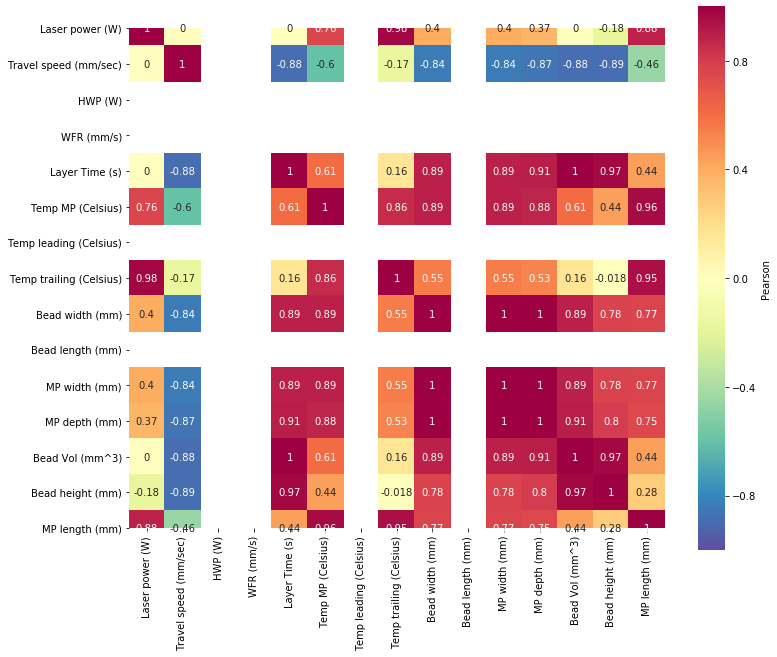

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10));
sns.heatmap(simulation.dataframe[simulation._inputs + simulation._outputs].corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

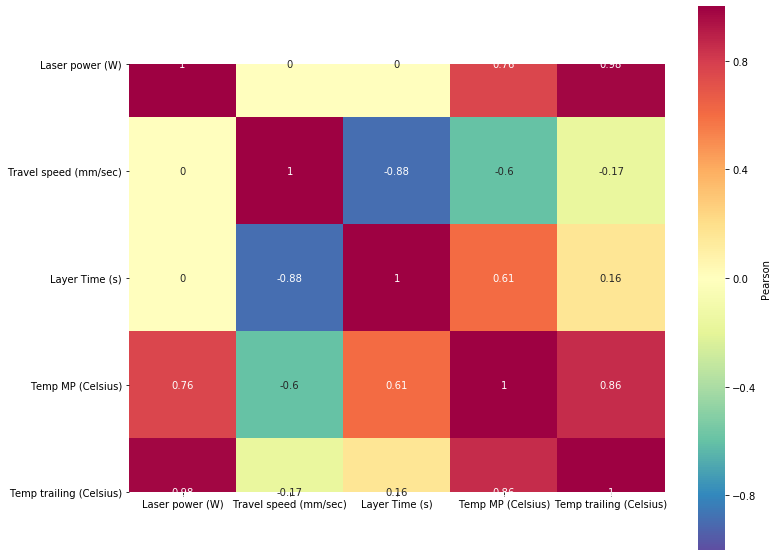

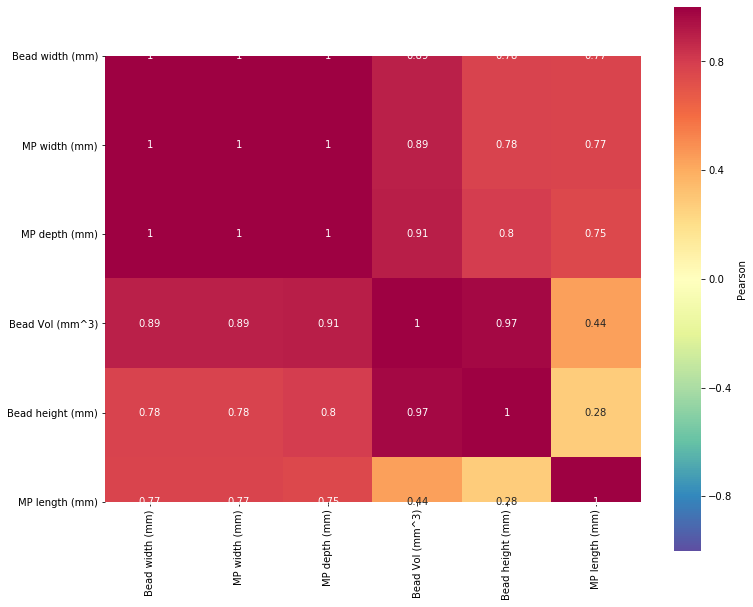

In [8]:
# drop degenerate data
simulation.set_input_columns(
    simulation.get_input_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(simulation.get_input_columns().corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

simulation.set_output_columns(
    simulation.get_output_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(simulation.get_output_columns().corr('pearson'),
            ax=ax, square=True, annot=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

## Experimental data

In [9]:
experimental = Data().read_excel("data/qualitymade-20200423.xlsx", index_col=0)

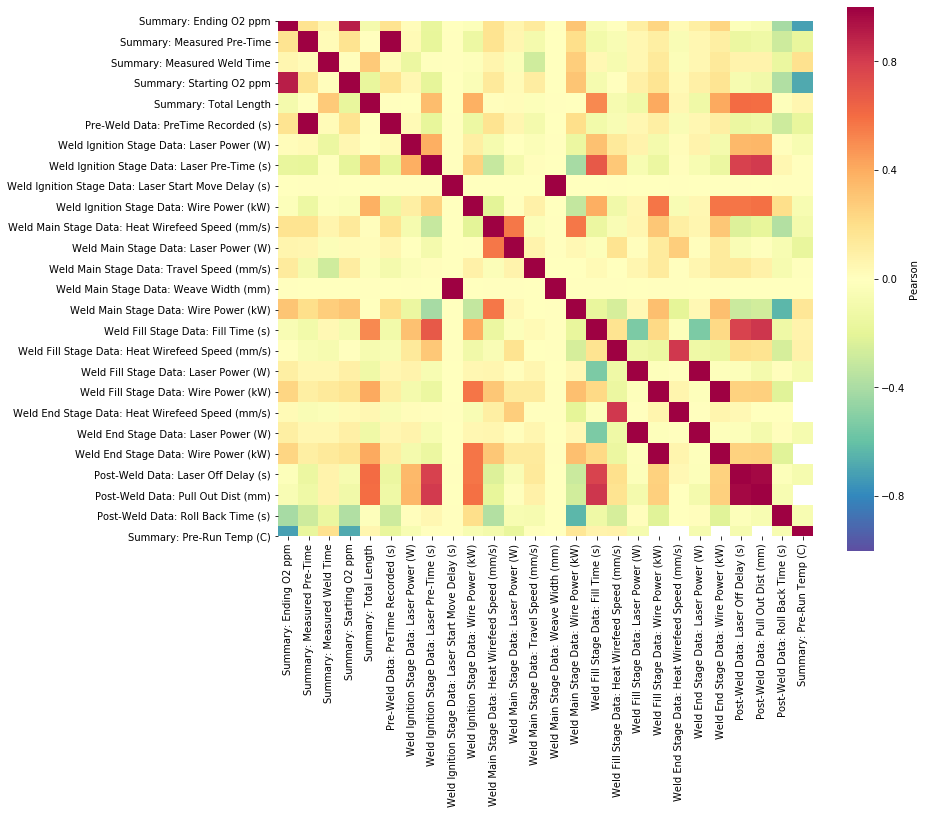

In [10]:
columns = [col for col in experimental.dataframe.columns.to_list()
           if ((col.startswith('Summary:') or
                col.startswith('Pre-Weld Data:') or
                col.startswith('Weld Ignition Stage Data:') or
                col.startswith('Weld Main Stage Data:') or
                col.startswith('Weld Fill Stage Data:') or
                col.startswith('Weld End Stage Data:') or
                col.startswith('Post-Weld Data:')) and not
               (col.endswith('Program') or
                col.endswith('(Hz)')))]

experimental.set_input_columns(columns)
experimental.set_input_columns(
    experimental.get_input_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(experimental.get_input_columns().corr('pearson'),
            ax=ax, square=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

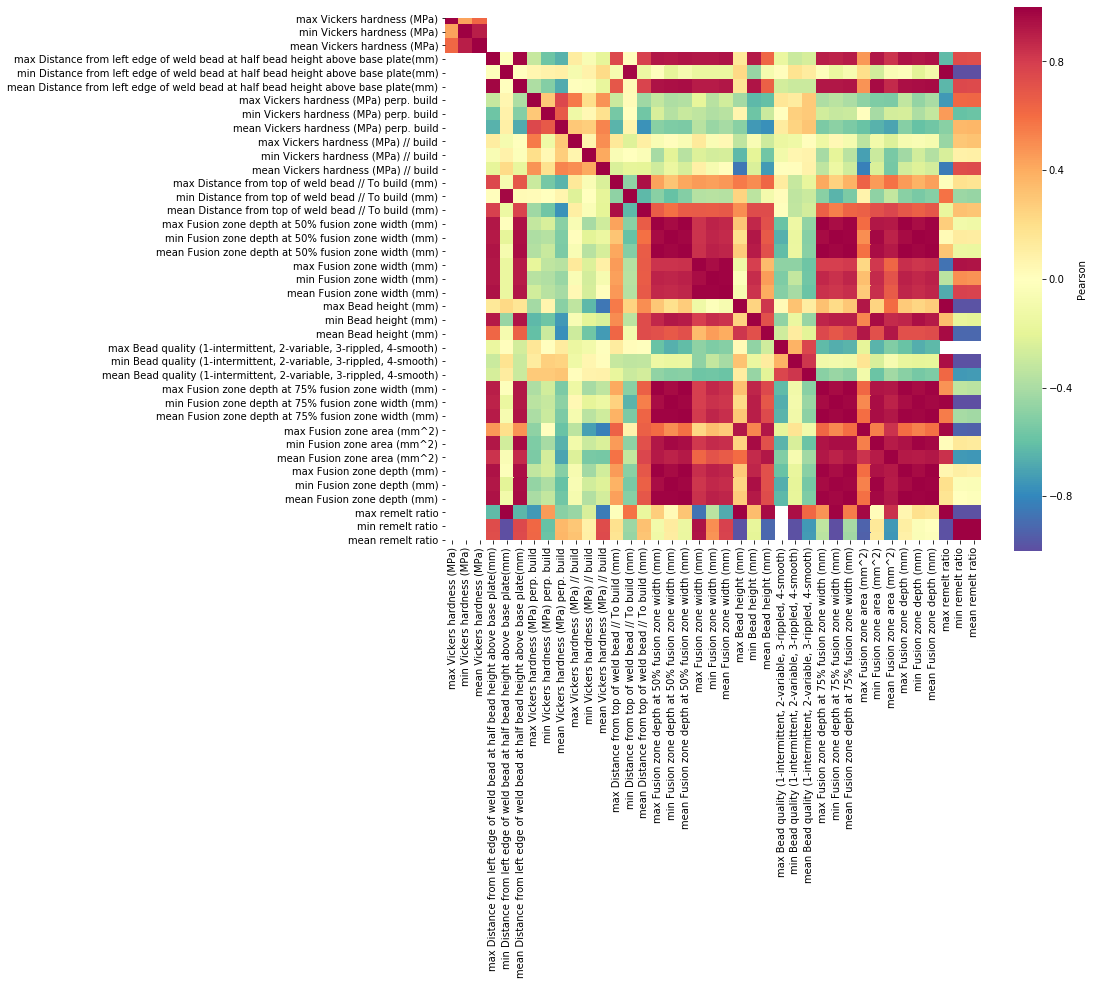

In [11]:
columns = [col for col in experimental.dataframe.columns.to_list()
           if ((col.startswith('mean') or
                col.startswith('min') or
                col.startswith('max')) and
               not col.endswith('Notes'))]

experimental.set_output_columns(columns)
experimental.set_output_columns(
    experimental.get_output_columns().corr('pearson').dropna(axis=1, how="all").columns.to_list(),
    reset=True)
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
sns.heatmap(experimental.get_output_columns().corr('pearson'),
            ax=ax, square=True,
            vmin=-1, vmax=1, cmap=plt.cm.Spectral_r,
            cbar_kws={'label': 'Pearson'});

# Build $\hat{y}_\text{expt}$ model

### Random Forest Imputation

Build a series of models to estimate missing values. Set each column, in turn as the target column:

1. Identify rows in the target column that are not NaN. Keep these rows.
2. Identify those columns fully populated in those rows.
3. Fit a model to predict target.
4. Predict missing target values.

### Check if imputation has already been done

In [12]:
imputedDataFilename="data/rfn-imputed-qualitymade-20200423.xlsx"

if os.path.isfile(imputedDataFilename):
  filled = pd.read_excel(imputedDataFilename)
  filled = filled.set_index("Sample Name")
else:
  filled = None

filled

,Summary: Ending O2 ppm,Summary: Measured Pre-Time,Summary: Measured Weld Time,Summary: Starting O2 ppm,Summary: Total Length,Pre-Weld Data: PreTime Recorded (s),Weld Ignition Stage Data: Laser Power (W),Weld Ignition Stage Data: Laser Pre-Time (s),Weld Ignition Stage Data: Laser Start Move Delay (s),Weld Ignition Stage Data: Wire Power (kW),...,mean Fusion zone depth at 75% fusion zone width (mm),max Fusion zone area (mm^2),min Fusion zone area (mm^2),mean Fusion zone area (mm^2),max Fusion zone depth (mm),min Fusion zone depth (mm),mean Fusion zone depth (mm),max remelt ratio,min remelt ratio,mean remelt ratio
Sample Name,,,,,,,,,,,,,,,,,,,,,
Feature4QMWall_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Feature4QMWall_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N00014-001-001,79.0,2.077,62.538,80.0,195.7,2.08,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.797386,-5.201646,-11.349693
N00014-001-002,74.0,2.073,19.521,75.0,195.7,2.07,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.839841,-17.002176,-10.079913
N00014-001-003,56.0,2.077,60.389,58.0,195.7,2.08,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.912144,-10.499103,-10.788275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
csm092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
csm093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
csm094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, LeaveOneOut

def as_dataframe(obj, prefix='x'):
    if not isinstance(obj, (pd.Series, pd.DataFrame)):
        obj = np.asarray(obj)
        try:
            nx, ny = obj.shape
            return pd.DataFrame(obj, columns=[f'{prefix}{i}' for i in range(nx)])
        except ValueError:
            return pd.Series(obj, name=f'{prefix}1').to_frame()
    else:
        try:
            # converting Series to DataFrame
            return obj.to_frame()
        except AttributeError:
            # object is a DataFrame
            return obj

if (filled is None) or (not use_cache):
  data = experimental.dataframe[experimental._inputs + experimental._outputs]
  filled = data.copy()

  for targetKey in data.columns.to_list():
    # rows that are not NaN in the target
    target = data[targetKey]
    isnanIndex = np.where(np.isnan(target))[0]
    labelIndex = np.where(~np.isnan(target))[0]

    # model data: features that are not NaN where label is not NaN
    df = data.iloc[labelIndex, :].dropna(axis=1)
    featureKeys = [col for col in df.columns.to_list() if col != targetKey]
    modelData = data[featureKeys + [targetKey]]

    # iterate over missing value
    print(f"Predicting {targetKey}")
    start = time.time()
    for i in isnanIndex:
        # get the subset of feature columns that are not NaN
        df = modelData.iloc[i, :].to_frame().transpose().dropna(axis=1)
        columns = df.columns.to_list()
        if df.shape[1] == 0:
            continue
        # set the feature and label data
        X = modelData[columns].iloc[labelIndex, :].values
        y = modelData.iloc[labelIndex, -1].values
        # fit the model
        model = Model(RandomForestRegressor(n_estimators=300,
                                            criterion="mse",
                                            max_features=0.8)).fit(X, y, cv=LeaveOneOut())
        # use the valid feature values
        x = modelData[columns].iloc[i, :].values[np.newaxis, :]
        # predict the y-value
        ypred = model.predict(x)[0]
        # use the score to esimate the error
        score = model._score['test_neg_mean_squared_error']
        rmse = np.sqrt(-np.mean(score))
        error = np.random.normal(scale=rmse)
        # insert the value + error
        filled[targetKey][i] = ypred + error
    elapsed = time.time() - start
    print(f"Elapsed time filling {targetKey}: {elapsed:.03f} s")
      
  # save results
  filled.to_excel(imputedDataFilename)
  print("Imputed data saved to '{imputedDataFilename}'.")
else:
  print(f"Imputed data read from '{imputedDataFilename}'.")

filled

Imputed data read from 'data/rfn-imputed-qualitymade-20200423.xlsx'.


,Summary: Ending O2 ppm,Summary: Measured Pre-Time,Summary: Measured Weld Time,Summary: Starting O2 ppm,Summary: Total Length,Pre-Weld Data: PreTime Recorded (s),Weld Ignition Stage Data: Laser Power (W),Weld Ignition Stage Data: Laser Pre-Time (s),Weld Ignition Stage Data: Laser Start Move Delay (s),Weld Ignition Stage Data: Wire Power (kW),...,mean Fusion zone depth at 75% fusion zone width (mm),max Fusion zone area (mm^2),min Fusion zone area (mm^2),mean Fusion zone area (mm^2),max Fusion zone depth (mm),min Fusion zone depth (mm),mean Fusion zone depth (mm),max remelt ratio,min remelt ratio,mean remelt ratio
Sample Name,,,,,,,,,,,,,,,,,,,,,
Feature4QMWall_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Feature4QMWall_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
N00014-001-001,79.0,2.077,62.538,80.0,195.7,2.08,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.797386,-5.201646,-11.349693
N00014-001-002,74.0,2.073,19.521,75.0,195.7,2.07,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.839841,-17.002176,-10.079913
N00014-001-003,56.0,2.077,60.389,58.0,195.7,2.08,6000.0,0.4,0.2,0.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.912144,-10.499103,-10.788275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
csm092,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
csm093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
csm094,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Compare the imputed dataset with the original dataset

/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/bkappes/opt/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


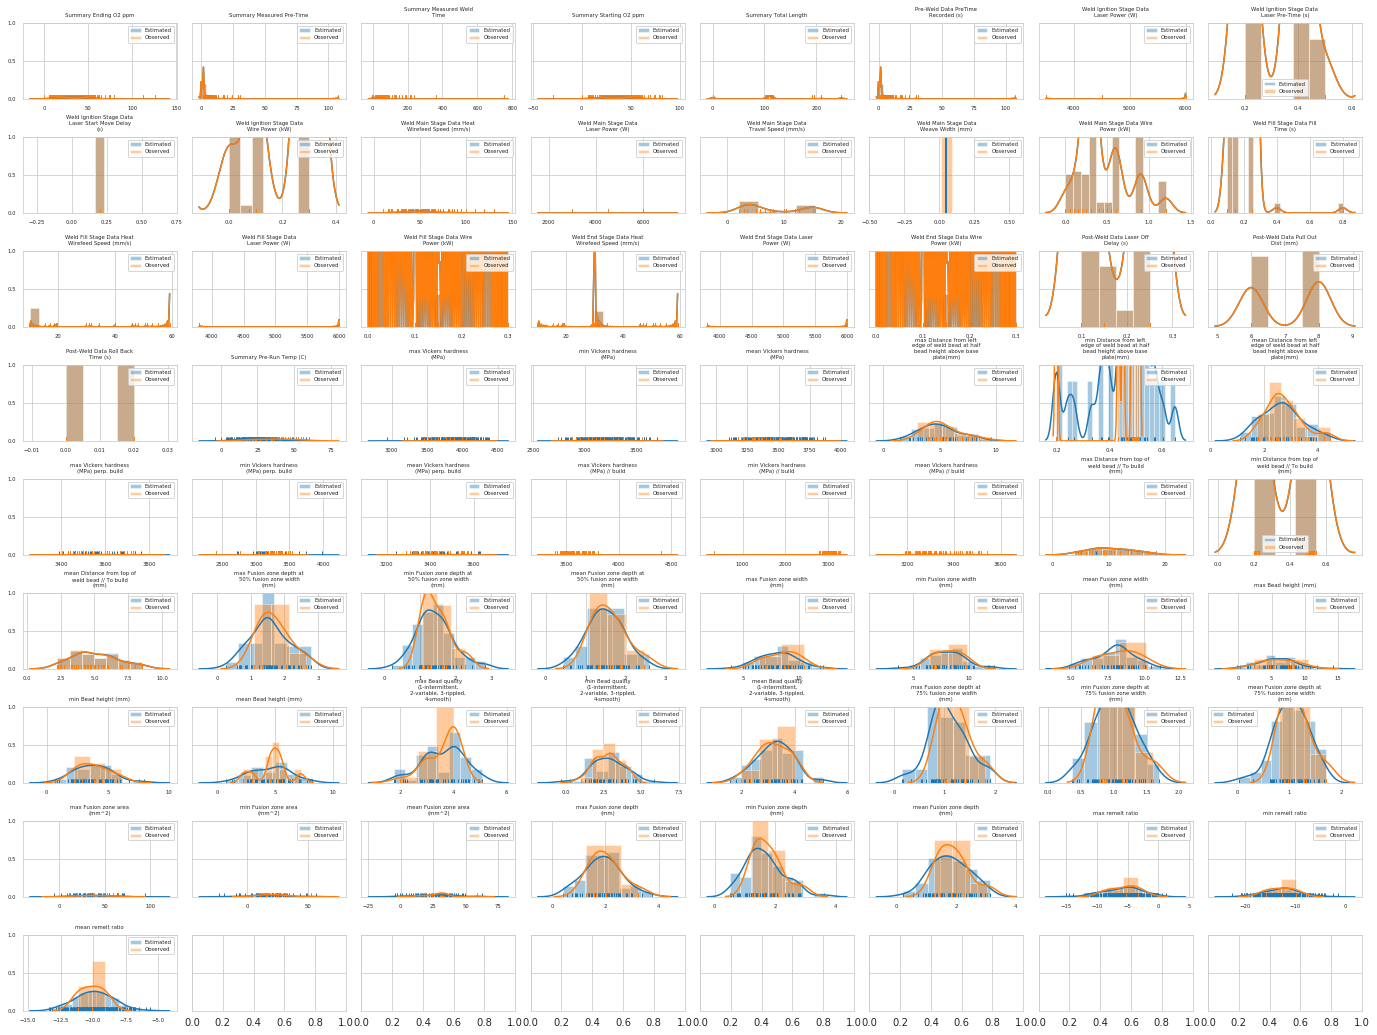

In [14]:
nx, ny = (9, 8)
with sns.axes_style("whitegrid"):
    fig, axes = plt.subplots(nx, ny, sharey=True, figsize=(24, 14))
    axes = axes.ravel()

    fontsize = 48/max(nx, ny)
    for ax, col in zip(axes, filled.columns):
        sns.distplot(filled[col].dropna(), rug=True, label="Estimated", ax=ax);
        sns.distplot(experimental.dataframe[col].dropna(), rug=True, label="Observed", ax=ax);
        # set title, splitting column name at 24 characters/line
        title = col
        lines = [line.strip() for line in title.split(':')]
        rows = []
        for line in lines:
            for word in line.split():
                if not rows:
                    rows.append(word)
                elif len(word) + len(rows[-1]) > 24:
                    rows.append(word)
                else:
                    rows[-1] = ' '.join((rows[-1], word))
        ax.set_title('\n'.join(rows));

        ax.legend(fontsize=fontsize);
        ax.set_ylim(0, 1);
        ax.set_xlabel("");
        for label in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                      ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(fontsize)

fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5/np.sqrt(nx), wspace=0.1)
if overwrite_files:
  fig.savefig("figs/rfn-imputation.pdf", bbox_inches="tight")

In [15]:
import re
with sns.axes_style("whitegrid"):
    fontsize = 24
    for col in filled.columns:
      filename = "figs/rnf_imputation_" + re.sub("\W+", "_", col) + ".png"
      if os.path.isfile(filename) and not overwrite_files:
        continue
      fig, ax = plt.subplots(figsize=(16,9))
      sns.distplot(filled[col].dropna(), rug=True, label="Estimated", ax=ax);
      sns.distplot(experimental.dataframe[col].dropna(), rug=True, label="Observed", ax=ax);
      # set title, splitting column name at 24 characters/line
      title = col
      lines = [line.strip() for line in title.split(':')]
      rows = []
      for line in lines:
          for word in line.split():
              if not rows:
                  rows.append(word)
              elif len(word) + len(rows[-1]) > 24:
                  rows.append(word)
              else:
                  rows[-1] = ' '.join((rows[-1], word))
      ax.set_title('\n'.join(rows));

      ax.legend(fontsize=fontsize);
      ax.set_ylim(0, 1);
      ax.set_xlabel("");
      for label in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                    ax.get_xticklabels() + ax.get_yticklabels()):
          label.set_fontsize(fontsize)
      fig.savefig(filename, dpi=300, bbox_inches="tight")
      plt.close(fig)

# fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5/np.sqrt(nx), wspace=0.1)
# if not os.path.isfile("figs/rfn-imputation.pdf") or overwrite_files:
#   fig.savefig("figs/rfn-imputation.pdf", bbox_inches="tight")

## Fit Experimental Data

### Use filled data from RFN imputation

In [16]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_validate

# featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))
# targetKeys = list(set(experimental._outputs).intersection(set(filled.columns.to_list())))

# df = filled[featureKeys + targetKeys].dropna()

# X = df[featureKeys].values

# experimentalModels = dict()
# for key in targetKeys:
#     print(f"Fitting {key}")
#     y = df[key].values
#     model = Model(RandomForestRegressor(n_estimators=300,
#                                         criterion="mse",
#                                         max_features=0.8),
#                   input_labels=featureKeys,
#                   output_label=key).fit(X, y, cv=5)
#     experimentalModels[key] = model

In [17]:
pickleExptModelsFilename = "data/grid-search-expt-models.pkl"

if os.path.isfile(pickleExptModelsFilename) and use_cache:
  import pickle
  
  with open(pickleExptModelsFilename, "rb") as ifs:
    experimentalModels = pickle.load(ifs)
  print(f"Read optimized experimental models from {pickleExptModelsFilename}.")
else:
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.model_selection import cross_validate, GridSearchCV

  featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))
  targetKeys = list(set(experimental._outputs).intersection(set(filled.columns.to_list())))

  df = filled[featureKeys + targetKeys].dropna()

  X = df[featureKeys].values

  parameters = {
    "n_estimators": [50, 100, 300],
    "criterion": ["mse", "mae"],
    "max_features": [0.1, 0.2, 0.5, 0.8, "sqrt", "log2", None],
    "bootstrap": [True, False],
    "oob_score": [True, False]
  }
  rfn = RandomForestRegressor(random_state=42)

  experimentalModels = dict()
  for key in targetKeys:
    print(f"Fitting {key}")
    y = df[key].values
    clf = GridSearchCV(rfn, parameters)
    clf.fit(X, y)
    experimentalModels[key] = clf
    
  if not os.path.isfile(pickleExptModelsFilename) or overwrite_files:
    with open(pickleExptModelsFilename, "wb") as ofs:
      pickle.dump(experimentalModels, ofs)

Read optimized experimental models from data/grid-search-expt-models.pkl.


In [18]:
# k = list(experimentalModels.keys())[2]

# model = experimentalModels[k]

# # x = model.cv_results_["rank_test_score"]
# # y = model.cv_results_["mean_test_score"]
# # err = model.cv_results_["std_test_score"]

# # fig, ax = plt.subplots(figsize=(16,9));
# # idx = np.argsort(x)
# # ax.errorbar(x[idx], y[idx], yerr=err[idx], fmt="o");

# print(f"Best score: {model.best_score_}")
# print(f"Best param: {model.best_params_}")

foo = {}
for i,k in enumerate(experimentalModels):
  m = experimentalModels[k]
  # name
  foo["name"] = foo.get("name", []) + [k]
  # score
  score = m.best_score_
  if score < -1e6:
    score = float('nan')
  foo["score"] = foo.get("score", []) + [np.abs(score)]
  # best parameters
  for key, value in m.best_params_.items():
    if key not in foo:
      foo[key] = len(experimentalModels)*[None]
    foo[key][i] = value

pd.DataFrame(foo)

,name,score,bootstrap,criterion,max_features,n_estimators,oob_score
0,mean Distance from top of weld bead // To buil...,0.026875,False,mae,0.8,50,False
1,mean Bead height (mm),0.033235,True,mae,log2,50,True
2,min Vickers hardness (MPa),1.100980,True,mse,log2,50,True
3,max Vickers hardness (MPa) // build,0.642676,False,mse,None,100,False
4,max Distance from left edge of weld bead at ha...,0.221650,False,mae,0.1,300,False
5,min Vickers hardness (MPa) // build,0.095355,True,mae,0.1,100,True
6,min remelt ratio,0.232546,False,mae,0.2,100,False
7,mean Fusion zone area (mm^2),0.159518,True,mae,0.2,300,True
8,min Distance from left edge of weld bead at ha...,1.383049,True,mae,0.1,300,True
9,max Fusion zone area (mm^2),0.153704,True,mse,None,100,True


In [19]:
# helper functions
def wrap(text, maxlen=24, split=":", join="\n"):
  # split at divider
  lines = [line.strip() for line in text.split(split)]
  rows = []
  for line in lines:
    for word in line.split():
      # split line into words
      if not rows:
        # edge case: first word
        rows.append(word)
      elif len(word) + len(rows[-1]) > maxlen:
        # if word would exceed the maximum line length, start next line
        rows.append(word)
      else:
        # add word if it fits within the maximum line length
        rows[-1] = ' '.join((rows[-1], word))
  return join.join(rows);

def plot_with_labels(model, X, y, title, scores, ax=None):
  if ax is None:
    ax = plt.gca()
  y_pred = model.predict(X)
  # scores to text
  def fmt(x):
    formatter = {
      float: "{:.2f}",
      np.float64: "{:.2f}"
    }.get(type(x), "{}")
    return formatter.format(x)
  scores = '\n'.join([f"{key}: {fmt(value)}" for key, value in scores.items()]).replace("_", " ")
  # wrap title
  title = wrap(title, maxlen=60, split=":", join="\n")
  # plot regression
  plot_regression_results(ax, y, y_pred, title, scores)
  

# process each feature/target in turn
featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))
targetKeys = list(set(experimental._outputs).intersection(set(filled.columns.to_list())))

df = filled[featureKeys + targetKeys].dropna()

X = df[featureKeys].values
  
import re

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 24}	
plt.rc('font', **font)

for name, clf in experimentalModels.items():
  filename = "figs/" + re.sub("_+", "_", re.sub("\W", "_", name)) + ".png"
  # comment out the next two lines if you want to overwrite the existing
  # files.
  if os.path.isfile(filename) and not overwrite_files:
    continue
  fig, ax = plt.subplots(figsize=(16,9))
  model = clf.best_estimator_
  scores = {clf.best_params_['criterion']: np.abs(clf.best_score_)}
  scores.update(clf.best_params_)
  plot_with_labels(model, X, df[name], name, scores, ax=ax)
  print(f"Writing to {filename}")
  fig.savefig(filename, dpi=300, bbox_inches="tight")
  plt.close(fig)

In [20]:
clf.best_params_

{'bootstrap': True,
 'criterion': 'mse',
 'max_features': 0.1,
 'n_estimators': 50,
 'oob_score': True}

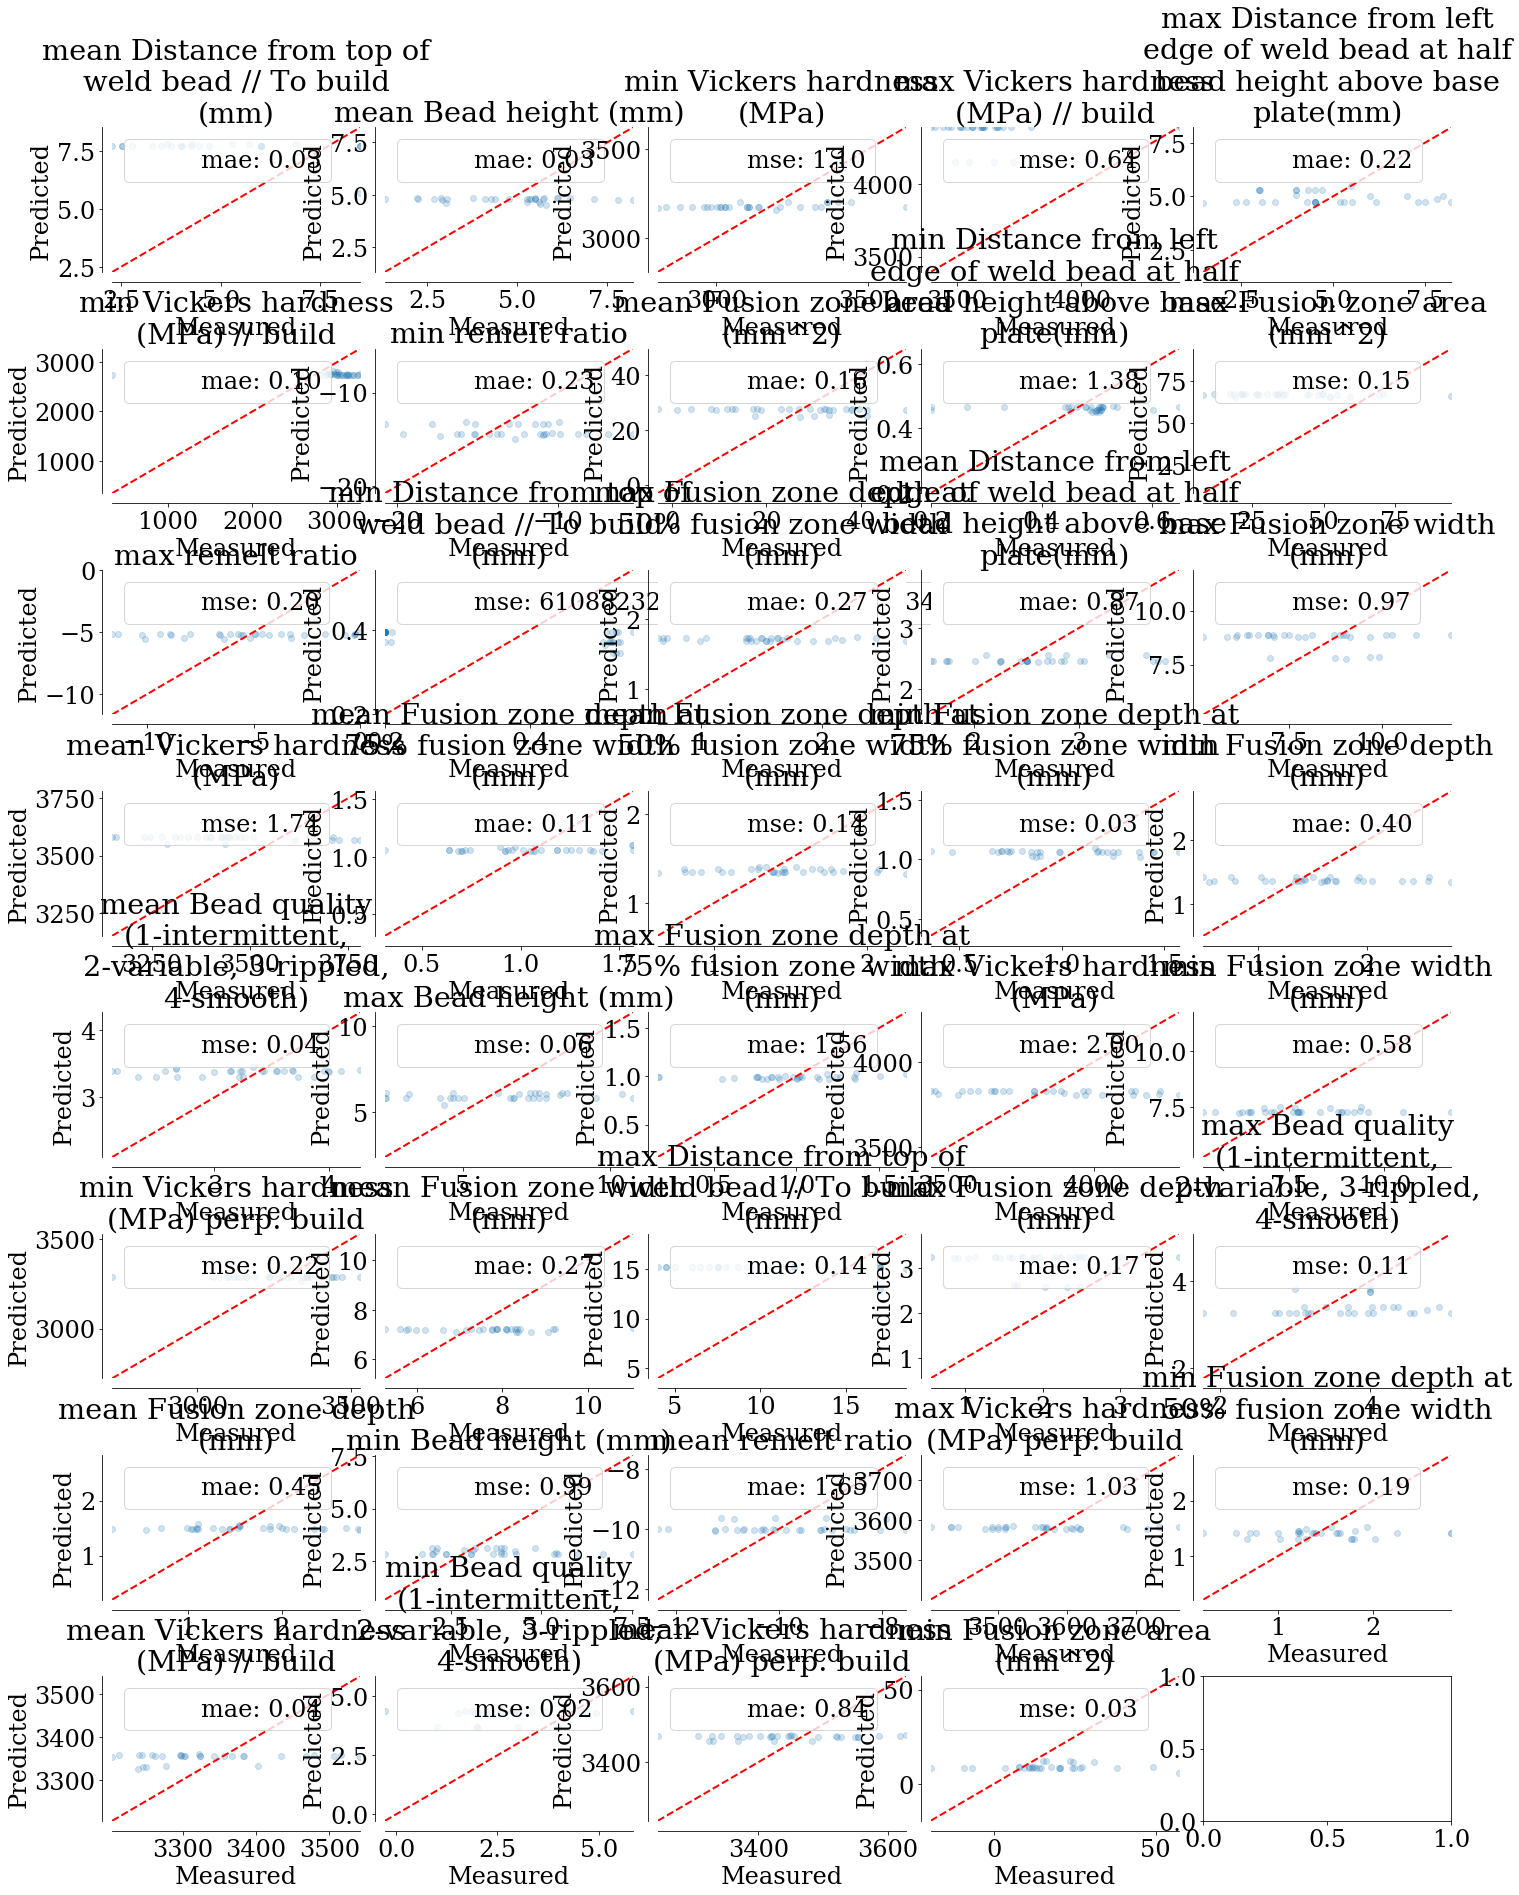

In [21]:
nx, ny = (8, 5)

fig, axes = plt.subplots(nx, ny, figsize=(24, 24))
axes = axes.ravel()

featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))
targetKeys = list(set(experimental._outputs).intersection(set(filled.columns.to_list())))

df = filled[featureKeys + targetKeys].dropna()

X = df[featureKeys].values

# fontsize = 48/max(nx, ny)
for ax, (name, clf) in zip(axes, experimentalModels.items()):
  model = clf.best_estimator_
  y_true = df[name]
  y_pred = model.predict(X)
  scores = f"{clf.best_params_['criterion']}: {np.abs(clf.best_score_):.2f}"
#   scores = model._score
#   scores = (r'$R^2={:.2g} \pm {:.2g}$' + '\n'
#             r'$RMSE={:.2g} \pm {:.2g}$')\
#       .format(np.mean(scores['test_r2']),
#               np.std(scores['test_r2']),
#               np.sqrt(-np.mean(scores['test_neg_mean_squared_error'])),
#               np.sqrt(np.std(scores['test_neg_mean_squared_error'])))

  # set title, splitting column name at 24 characters/line
  title = name
  lines = [line.strip() for line in title.split(':')]
  rows = []
  for line in lines:
      for word in line.split():
          if not rows:
              rows.append(word)
          elif len(word) + len(rows[-1]) > 24:
              rows.append(word)
          else:
              rows[-1] = ' '.join((rows[-1], word))
  title = '\n'.join(rows);

  plot_regression_results(ax, y_true, y_pred, title, scores)

#     ax.legend(fontsize=fontsize);
#     ax.set_ylim(0, 1);
#     ax.set_xlabel("");
#     for label in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
#                   ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(fontsize)

fig.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5/np.sqrt(nx), wspace=0.1);
if overwrite_files:
  fig.savefig("figs/rfn-impute-experimental-fits.pdf", bbox_inches='tight');

### Use a simple imputer to fill in missing data

# Build $\hat{y}_\text{sim}$ model

In [22]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import cross_validate, LeaveOneOut

pickleSimModelsFilename = "data/grid-search-sim-models.pkl"

Xsim = simulation.get_input_columns().values

if os.path.isfile(pickleSimModelsFilename) and use_cache:
  with open(pickleSimModelsFilename, "rb") as ifs:
    simulationModels, ysim = pickle.load(ifs)
  print(f"Read optimized simulation model parameters from {pickleSimModelsFilename}.")
else:
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.model_selection import cross_validate, GridSearchCV, LeaveOneOut
  
  parameters = {
    "n_estimators": [50, 100, 300],
    "criterion": ["mse", "mae"],
    "max_features": [0.1, 0.2, 0.5, 0.8, "sqrt", "log2", None],
    "bootstrap": [True, False],
    "oob_score": [True, False]
  }
  
  rfn = RandomForestRegressor(random_state=42)

  df = simulation.get_output_columns()
  simulationModels = dict()
  ysim = dict()
  for key in df:
      print(f"Fitting {key}")
      y = df[key].values
      ysim[key] = y
      clf = GridSearchCV(rfn, parameters)
      clf.fit(Xsim, y)
      simulationModels[key] = clf

  if not os.path.isfile(pickleSimModelsFilename) or overwrite_files:
    with open(pickleSimModelsFilename, "wb") as ofs:
      pickle.dump((simulationModels, ysim), ofs)

Read optimized simulation model parameters from data/grid-search-sim-models.pkl.


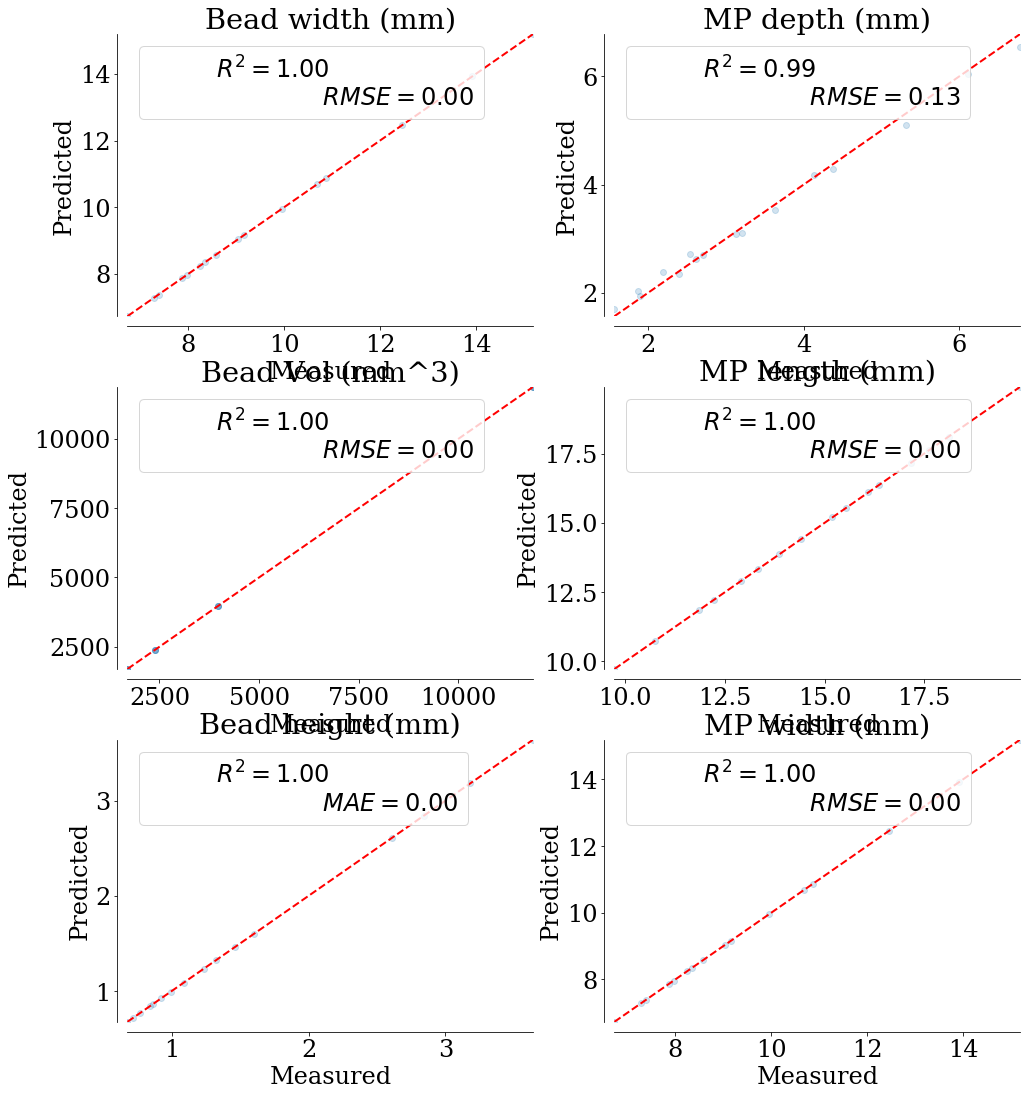

In [23]:
def get_metric(model, y_true, y_pred):
  from sklearn.metrics import mean_absolute_error, mean_squared_error
  return {
    'mae': ('MAE', mean_absolute_error(y_true, y_pred)),
    'mse': ('RMSE', np.sqrt(mean_squared_error(y_true, y_pred)))
  }[model.criterion]

fig, ax = plt.subplots(3, 2, figsize=(16, 14))
ax = ax.ravel()

Xsim = simulation.get_input_columns().values

for ax, (name, model) in zip(ax, simulationModels.items()):
  model = model.best_estimator_
  y_true = ysim[name]
  y_pred = model.predict(Xsim)
  score = model.score(Xsim, y_true)
  method, value = get_metric(model, y_true, y_pred)
  scores = """$R^2={score:.2f}$
              ${method:s}={metric:.2f}$""".format(score=(score),
                                                  method=(method),
                                                  metric=float(value))
  plot_regression_results(ax, y_true, y_pred, name, scores)
#   y_true = model._y
#   y_pred = model.predict(model._X)
#   scores = (r'$R^2={:.2f} \pm {:.2f}$' + '\n'
#             r'$RMSE={:.2f} \pm {:.2f}$')\
#       .format(np.nanmean(scores['test_r2']),
#               np.nanstd(scores['test_r2']),
#               np.sqrt(-np.mean(scores['test_neg_mean_squared_error'])),
#               np.sqrt(np.std(scores['test_neg_mean_squared_error'])))
#   plot_regression_results(ax, y_true, y_pred, name, scores)

plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.25, wspace=0.2)

# Estimate $\hat{y}_\text{expt}$ and $\hat{y}_\text{sim}$ from random inputs

The two models are fit over different phase spaces, $A$ and $B$, forming a joint phase space, $P = A \cup B$. However, these models may be compared if there exists an intersection in those phase spaces, $C = A \cap B$. The difference in their phase spaces, $D_A = A - B$ and $D_B = B - A$, act as a source of uncontrolled error.

Therefore, to develop a model that maps between the $\hat{y}_\text{expt}$ and $\hat{y}_\text{sim}$, uniformly sample from multivariate distributions in $C$, $D_A$, and $D_B$. The sample vector in the phase space of the experimental model (model A) is $Q_A = C_A + U(D_A)$ and in the phase space of the simulation model (model B) is $Q_B = C_B + U(D_B)$ under the condition that $C_A = C_B = U(C)$. $U(\cdot)$ indicates randomly sampling from a uniform distribution.

1. Uniformly sample data in the range of all input parameters. For variables common to both, $C$, there are two options:
    1. The domain is the intersection of the domains of the experimental and simulation, i.e. $\max(\min A, \min B)$ to $\min(\max A, \max B)$.
    2. The domain is the union of the experimental and simulation domains, i.e. $\min(\min A, \min B)$ to $\max(\max A, \max B)$.
2. Predict estimates.
3. Examine estimates to intuit functional relationship.

In [24]:
class BinarySemanticMap:
  """
  Given two dataframes, identifies an equivalence between
  two columns.
  
  :property A: One pd.DataFrame.
  :property B: The other pd.DataFrame.
  :property pairs: The list of equivalen keys,
      [(key A, key B)_1, (key A, key B)_2, ...]
  
  Methods
  :equal(keyA, keyB): Sets the equivalence between key A and key B.
      These need not be provided in the same order as the initial dataframes.
  :remove(keyA, keyB=None): Removes the (keyA, keyB) pair. If keyB
      is None, then all pairs with keyA are removed.
  """
  def __init__(self, dfA, dfB):
    self._A = dfA
    self._B = dfB
    self._equalKeys = []
    
  @property
  def A(self):
    return self._A
  
  @property
  def B(self):
    return self._B
  
  @property
  def pairs(self):
    return self._equalKeys
  
  def equal(self, keyA, keyB):
    """
    Set an equivalence between keys in the Semantic Map Pair.
    
    :param keyA, hashable: One key in the pair.
    :param keyB, hashable: Second key in the pair.
    :returns: self
    """
    kA = keyA if (keyA in self._A) else None
    kB = keyB if (keyB in self._B) else None
    if not (kA and kB):
      kA = keyB if (keyB in self._A) else None
      kB = keyA if (keyA in self._B) else None
    if not (kA and kB):
      raise KeyError(f"{keyA} and {keyB} where not found in the Semantic Map Pairs.")
    self._equalKeys.append((kA, kB))
    return self
  
  def remove(self, keyA, keyB=None):
    """
    Removes an key-equivalence.
    
    :param keyA, hashable: One key in the pair to be removed.
    :param keyB, (hashable or None): Second key in the pair to be removed. If None, remove
         all pairs where `keyA` is present.
    :returns: self
    """
    def keep(pair, xA, xB):
      return not ((xA in pair) and ((xB in pair) or (xB is None)))
    self._equalKeys = [pair for pair in self._equalKeys if keep(pair, keyA, keyB)]
    return self


class LinearRange:
  """
  Defines a range from the values in a vector. This does not update with changes
  to the values in the vector.
  
  :Properties:
  :lower: Returns the scaled lower bound of the LinearRange.
  :upper: Returns the scaled upper bound of the LinearRange.
  :vector_limits: Returns the unscaled minimum and maximum values in the vector.
  
  :Methods:
  :set_lower(value): Sets the lower bound of the LinearRange (scaled).
  :set_upper(value): Sets the upper bound of the LinearRange (scaled).
  :scale(value): Scales the value as a fraction of the domain of the LinearRange.
  :unscale(value: Unscales the value into a real space equivalent.
  """
  def __init__(self, vec):
    self._lower = 0.
    self._upper = 1.
    # location and scale
    self._loc = np.min(vec)
    self._scale = np.max(vec) - np.min(vec)

  def __contains__(self, x):
    s = self.scale(x)
    return (self.lower <= s) & (s <= self.upper)
    
  @property
  def lower(self):
    return self._lower
  
  def set_lower(self, value):
    self._lower = value
    return self
    
  @property
  def upper(self):
    return self._upper
  
  def set_upper(self, value):
    self._upper = value
    return self
  
  @property
  def vector_limits(self):
    return (self._loc, self._loc + self._scale)
  
  def scale(self, x):
    x = np.asarray(x)
    return (x - self._loc)/self._scale
  
  def unscale(self, s):
    s = np.asarray(s)
    return self._scale * s + self._loc

  
# - Types can be (continuous, discrete)
# - Pair values can be (equal, scaled/linear, functionally related)
class CommonDomains(BinarySemanticMap):
  """
  Identifies the common (overlapping) domain between two data frames.
  This is a type of BinarySemanticMap. The overlapping domains are
  identified on equivalent columns, using a LinearRange to define the
  overlapping domain.
  
  :Methods:
  :uniform(num): Returns a pair of dataframes where all values are sampled
      on the underlying domain of the column. Eqivalent columns (as defined
      by the BinarySemanticMap) are selected based on their overlapping
      domains.
  :equal(keyA, keyB): In addition to setting the equivalent keys, also
      identifies the overlapping domains.
  """
  def __init__(self, dfA, dfB):
    super().__init__(dfA, dfB)
    self._ADomains = {k:LinearRange(self.A[k]) for k in self.A}
    self._BDomains = {k:LinearRange(self.B[k]) for k in self.B}
    
  def _set_equivalent_keys(self, XA, XB):
    """
    Ensure the matching key pairs in the two DataFrames are equivalent.
    """
    for kA, kB in self.pairs:
      dA, dB = self._ADomains[kA], self._BDomains[kB]
      for i, (Aval, Bval) in enumerate(zip(XA[kA], XB[kB])):
        AinB = Aval in dB
        BinA = Bval in dA
        if AinB:
          XB.loc[i, kB] = XA.loc[i, kA]
        elif BinA:
          XA.loc[i, kA] = XB.loc[i, kB]
        else:
          XA.loc[i, kA] = np.nan
          XB.loc[i, kB] = np.nan
    XA.dropna(inplace=True)
    XB.dropna(inplace=True)
    return self
    
  def uniform(self, num:int=1):
    """
    Draw uniformly from the valid domains in each key.
    
    :param num, int: Number of instances to draw.
    :returns: (XA, XB)
    """
    import pandas as pd
    XA, XB = [pd.DataFrame({k: lr.unscale(np.random.uniform(lr.lower, lr.upper, size=num))
                            for k, lr in domain.items()})
              for domain in (self._ADomains, self._BDomains)]
    # make sure pairs are equivalent
    self._set_equivalent_keys(XA, XB)
    return (XA, XB)

  def equal(self, keyA, keyB):
    """
    Set an equivalence between keys in the Semantic Map Pair.
    
    :param keyA, hashable: One key in the pair.
    :param keyB, hashable: Second key in the pair.
    :returns: self
    """
    super().equal(keyA, keyB)
    kA, kB = self._equalKeys[-1]
    vA, vB = self.A[kA], self.B[kB]
    dA, dB = LinearRange(vA), LinearRange(vB)
    # ===========================================
    # lowerA = min(max(0, dA.scale(mB)), 1)
    # upperA = max(min(1, dA.scale(MB)), 0)
    # ===========================================
    # domain A, dA: mA|---------|MA
    # domain B, dB:       mB|-------------|MB
    # dA = [sB, 1], sB = (mB-mA)/(MA-mA) + mA
    # dB = [0, SA], SA = (MA-mB)/(MB-mB) + mB
    # ===========================================
    # domain A, dA: mA|---------|MA
    # domain B, dB:     mB|----|MB
    # dA = [sB, SB]
    # dB = [0, 1]
    # ===========================================
    # domain A, dA:        mA|---------|MA
    # domain B, dB: mB|-------------|MB
    # dA = [0, SB]
    # dB = [sA, 1]
    # ===========================================
    # domain A, dA: mA|-------|MA
    # domain B, dB:             mB|----------|MB
    # dA = [1, 1]
    # dB = [0, 0]
    # ===========================================
    # dA
    m, M = dA.scale(dB.vector_limits)
    dA.set_lower(min(max(0, m), 1))
    dA.set_upper(max(min(1, M), 0))
    # dB
    m, M = dB.scale(dA.vector_limits)
    dB.set_lower(min(max(0, m), 1))
    dB.set_upper(max(min(1, M), 0))
    # Set domain A's limit. It can only shrink to comply with previous domains.
    d = self._ADomains[kA]
    l, u = d.lower, d.upper
    l, u = (max(l, 0), min(u, 1))
    self._ADomains[kA].set_lower(l)
    self._ADomains[kA].set_upper(u)
    # Set domain B's limit. It can only shrink to comply with previous domains.
    d = self._BDomains[kB]
    l, u = d.lower, d.upper
    l, u = (max(l, 0), min(u, 1))
    self._BDomains[kB].set_lower(l)
    self._BDomains[kB].set_upper(u)
    # done
    return self

In [25]:
featureKeys = list(set(experimental._inputs).intersection(set(filled.columns.to_list())))

dfExpt = filled[featureKeys].dropna()
dfSim = simulation.get_input_columns()

cdom = CommonDomains(dfExpt, dfSim)\
    .equal("Weld Main Stage Data: Laser Power (W)", "Laser power (W)")\
    .equal("Summary: Measured Weld Time", "Layer Time (s)")\
    .equal("Weld Main Stage Data: Travel Speed (mm/s)", "Travel speed (mm/sec)")

In [26]:
Xexp, Xsim = cdom.uniform(1000)

In [27]:
print('\n'.join([k for k in simulationModels.keys()]))
print()
print('\n'.join([k for k in experimentalModels.keys() if k.startswith('mean')]))

Bead width (mm)
MP depth (mm)
Bead Vol (mm^3)
MP length (mm)
Bead height (mm)
MP width (mm)

mean Distance from top of weld bead // To build (mm)
mean Bead height (mm)
mean Fusion zone area (mm^2)
mean Distance from left edge of weld bead at half bead height above base plate(mm)
mean Vickers hardness (MPa)
mean Fusion zone depth at 75% fusion zone width (mm)
mean Fusion zone depth at 50% fusion zone width (mm)
mean Bead quality (1-intermittent, 2-variable, 3-rippled, 4-smooth)
mean Fusion zone width (mm)
mean Fusion zone depth (mm)
mean remelt ratio
mean Vickers hardness (MPa) // build
mean Vickers hardness (MPa) perp. build


In [28]:
equivalentModels = {
  "bead width": (experimentalModels["mean Fusion zone width (mm)"].best_estimator_,
                 simulationModels["Bead width (mm)"].best_estimator_),
  "mp depth": (experimentalModels["mean Fusion zone depth (mm)"].best_estimator_,
               simulationModels["MP depth (mm)"].best_estimator_),
  "bead height": (experimentalModels["mean Bead height (mm)"].best_estimator_,
                  simulationModels["Bead height (mm)"].best_estimator_)
}

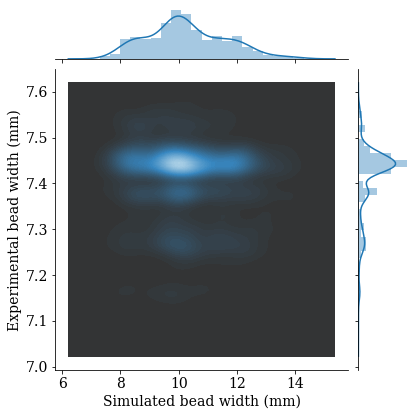

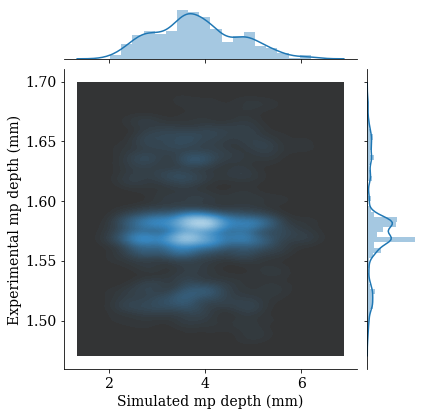

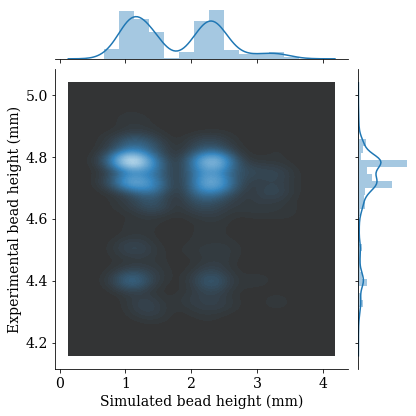

In [29]:
from scipy.stats import pearsonr
import seaborn as sns

font = {
  "family": "serif",
  "size": 14
}
plt.rc("font", **font);

for name in ("bead width", "mp depth", "bead height"):
  x = equivalentModels[name][1].predict(Xsim)
  y = equivalentModels[name][0].predict(Xexp)
  
  xlabel = f"Simulated {name} (mm)"
  ylabel = f"Experimental {name} (mm)"
  df = pd.DataFrame({xlabel: x, ylabel: y})

  cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
  g = sns.JointGrid(x=xlabel, y=ylabel, data=df);
#   g.plot_joint(sns.kdeplot, cmap=cmap, n_levels=60, shade=True);
  g.plot_joint(sns.kdeplot, cmap="Blues_d", n_levels=60, shade=True);
  g.plot_marginals(sns.distplot, kde=True);
  
  filename = f"figs/{name.replace(' ', '-')}.png"
  if not os.path.isfile(filename) or overwrite_files:
    plt.savefig(filename, dpi=300, bbox_inches="tight");

In [104]:
# Cacluate coefficient of determination and Pearson R
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

stats = dict()
for name in ("bead width", "mp depth", "bead height"):
  x = equivalentModels[name][1].predict(Xsim)
  y = equivalentModels[name][0].predict(Xexp)
  
  rsq = r2_score(x, y)
  pr = pearsonr(x, y)
  
  stats['name'] = stats.get('name', []) + [name]
  stats['R2'] = stats.get('R2', []) + [rsq]
  stats['Pearson R'] = stats.get('Pearson R', []) + [pr]

pd.DataFrame(stats).set_index('name')

,R2,Pearson R
name,,
bead width,-4.536362,"(-0.07383411016072385, 0.019537825051936096)"
mp depth,-6.855664,"(0.02952920636655691, 0.350907232797559)"
bead height,-18.013419,"(-0.08990673538157884, 0.004436841534327208)"


In [63]:
from time import time
import warnings

warnings.filterwarnings("ignore")

# Xsim and Xexp defined in an earlier cell
# featureKeys defined in earlier cell
pickleJointModelsFilename = f"data/grid-search-joint-models.pkl"

if os.path.isfile(pickleJointModelsFilename) and use_cache:
  with open(pickleJointModelsFilename, "rb") as ifs:
    jointModels = pickle.load(ifs)
  print(f"Read optimized simulation model parameters from {pickleJointModelsFilename}.")
else:
  from sklearn.ensemble import RandomForestRegressor
  from sklearn.model_selection import cross_validate, GridSearchCV, LeaveOneOut

  parameters = {
    "n_estimators": [50, 100, 300],
    "criterion": ["mse", "mae"],
    "max_features": [0.1, 0.2, 0.5, 0.8, "sqrt", "log2", None],
    "bootstrap": [True, False],
    "oob_score": [True, False]
  }

  rfn = RandomForestRegressor(random_state=42)

  jointModels = dict()
  for name, model in equivalentModels.items():
    print(f"Fitting {name}")
    start = time()
    yexp = model[0].predict(Xexp.values)
    ysim = model[1].predict(Xsim.values)
    X = np.concatenate((Xexp, ysim[:, np.newaxis]), axis=1)
    clf = GridSearchCV(rfn, parameters)
    clf.fit(X, yexp)
    jointModels[name] = clf
    print("[elapsed]: {:.3f} s".format(time() - start))

  if not os.path.isfile(pickleJointModelsFilename) or overwrite_files:
    with open(pickleJointModelsFilename, "wb") as ofs:
      pickle.dump(jointModels, ofs)

Fitting bead width
[elapsed]: 3492.154 s
Fitting mp depth
[elapsed]: 2773.319 s
Fitting bead height
[elapsed]: 2543.753 s


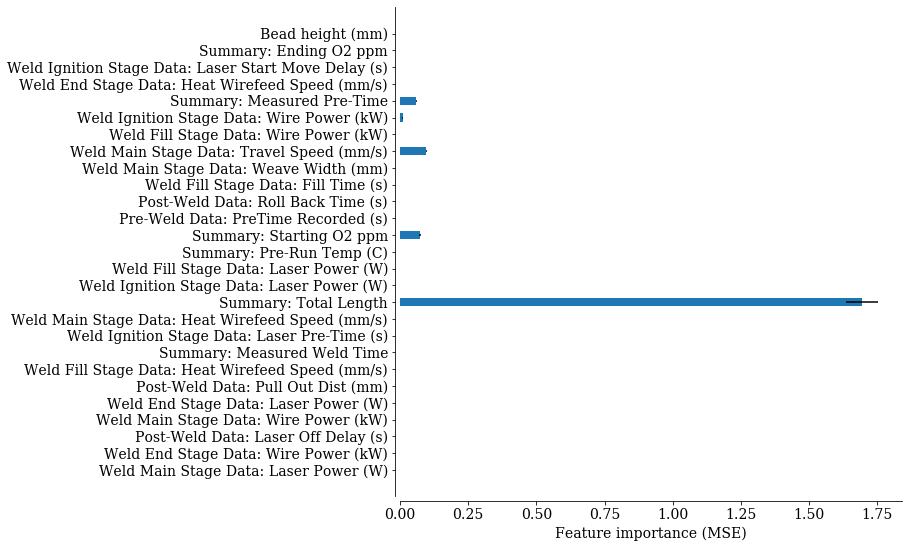

In [79]:
from sklearn.inspection import permutation_importance

name = 'bead height'
label = "Bead height (mm)"

# get feature importance
model = equivalentModels[name]
yexp = model[0].predict(Xexp.values)
ysim = model[1].predict(Xsim.values)[:, np.newaxis]
X = np.concatenate((Xexp, ysim), axis=1)
featureImportance = permutation_importance(jointModels[name].best_estimator_, X, yexp, random_state=217)

model = jointModels[name].best_estimator_

fig, ax = plt.subplots(figsize=(9, 9))
labels = list(featureKeys) + [label]
# heights = model.feature_importances_
# pos = np.arange(model.feature_importances_.size)
heights = featureImportance.importances_mean
err = featureImportance.importances_std
pos = np.arange(len(heights))
ax.barh(pos, heights, xerr=err,
        align='center',
        height=0.5,
        tick_label=labels);
sns.despine(ax=ax, offset=5)
ax.set_xlabel(f"Feature importance ({model.criterion.upper()})");

filename = "figs/{}-feature-importance.pdf".format(name.replace(" ", "-"))
if not os.path.isfile(filename) or overwrite_files:
    plt.savefig(filename, bbox_inches="tight");

In [84]:
model = experimentalModels["mean Bead height (mm)"].best_estimator_

In [102]:
df = pd.concat((experimental.get_input_columns(),
                experimental.get_output_columns()["mean Bead height (mm)"]), axis=1)
df.loc[~df["mean Bead height (mm)"].isna(), :]

# model.score(X, y)

,Summary: Ending O2 ppm,Summary: Measured Pre-Time,Summary: Measured Weld Time,Summary: Starting O2 ppm,Summary: Total Length,Pre-Weld Data: PreTime Recorded (s),Weld Ignition Stage Data: Laser Power (W),Weld Ignition Stage Data: Laser Pre-Time (s),Weld Ignition Stage Data: Laser Start Move Delay (s),Weld Ignition Stage Data: Wire Power (kW),...,Weld Fill Stage Data: Laser Power (W),Weld Fill Stage Data: Wire Power (kW),Weld End Stage Data: Heat Wirefeed Speed (mm/s),Weld End Stage Data: Laser Power (W),Weld End Stage Data: Wire Power (kW),Post-Weld Data: Laser Off Delay (s),Post-Weld Data: Pull Out Dist (mm),Post-Weld Data: Roll Back Time (s),Summary: Pre-Run Temp (C),mean Bead height (mm)
Sample Name,,,,,,,,,,,,,,,,,,,,,
N00014-002-16A,14.0,0.0,0.0,22.0,0.0,0.0,6000.0,0.2,0.2,0.3,...,6000.0,0.3,30.0,6000.0,0.3,0.1,6.0,0.02,NaN,5.605333
N00014-002-A09,27.0,0.0,0.0,47.0,0.0,0.0,6000.0,0.2,0.2,0.3,...,6000.0,0.3,30.0,6000.0,0.3,0.1,6.0,0.02,NaN,5.275000
N00014-002-A10,32.0,0.0,0.0,33.0,0.0,0.0,6000.0,0.2,0.2,0.3,...,6000.0,0.3,30.0,6000.0,0.3,0.1,6.0,0.02,NaN,3.024000
csm068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.241000
csm070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.577000
csm074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.875500
csm075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.286500
csm078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.623500
csm081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.301500


In [92]:
y.size

334